In [17]:

import numpy as np
from util.plot import plot_cdf,color_list,plot_cdf_sub,plot_line
from util.consts import SeqCodeEvent
import pandas as pd
import re
from collections import defaultdict
import matplotlib.pyplot as plt

In [25]:
dir_input="/data2/lichenni/path_perflow_busy"
topo_type="_topo-pl-x_"
lr=10
data_list=[]
# for shard in np.arange(1000):
for shard in [0]:
    for n_flows in [2000]:
        for n_hosts in [21]:
            for shard_seed in [0]:
                topo_type_cur=topo_type.replace("-x_",f"-{n_hosts}_")+"s%d"%(shard_seed)
                spec=f"shard{shard}_nflows{n_flows}_nhosts{n_hosts}_lr{lr}Gbps"
                dir_input_tmp = f"{dir_input}/{spec}"
                
                fat = np.load(f'{dir_input}/{spec}/fat.npy')
                fct = np.load(f'{dir_input}/{spec}/fct{topo_type_cur}.npy')
                if len(fat) == len(fct):
                    data_list.append((spec,topo_type_cur))
print(f"len(data_list): {len(data_list)}")
# Define a pattern to match the log line
log_pattern = re.compile(r"(\d+)\s+n:(\d+)\s+(\d+):(\d+)\s+(\d+)\s+(\w+)\s+ecn:(\d+)\s+(0b[0-9a-f]+)\s+(0b[0-9a-f]+)\s+(\d+)\s+(\d+)\s+(\w+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\((\d+)\)\s+(\d+)\s+(\d+)\s+(\d+)")
# Create a DataFrame
columns = ["timestamp", "node", "src_port", "queue", "queue_length", "event", "ecn", "src_addr", "dst_addr", 
           "src_port_num", "dst_port_num", "packet_type", "seq_num", "tx_timestamp", "priority_group", "packet_size", 
           "payload_size", "flow_id", "queue_event", "n_activate_flows"]

len(data_list): 1


In [48]:

timestamp_to_period_gt=[[1000000000,0]]
timestamp_to_period_sampled=[[1000000000,0]]
timestamp_to_period_sampled_merge=[[1000000000,0]]
peak_gt=1.0
peak_sampled=0.8
peak_sampled_merge=1.2
queue_threshold=0
for spec_idx,(spec,topo_type) in enumerate(data_list):
    print(f"spec_idx: {spec_idx}")
    input_tmp=f"{dir_input}/{spec}"
    # List to hold parsed log data
    log_data = []

    # Read the log file
    with open(f'{input_tmp}/mix{topo_type}.log', 'r') as file:
        log_data = [match.groups() for line in file if (match := log_pattern.match(line))]


    df = pd.DataFrame(log_data, columns=columns)

    # Convert relevant columns to appropriate data types
    df["timestamp"] = pd.to_numeric(df["timestamp"])
    df["seq_num"] = pd.to_numeric(df["seq_num"])
    df["flow_id"] = pd.to_numeric(df["flow_id"])
    df["qlen"]=pd.to_numeric(df["queue_length"])
    df["queue_event"]=pd.to_numeric(df["queue_event"])
    df["n_activate_flows"]=pd.to_numeric(df["n_activate_flows"])
    qlen_prev=0
    n_periods_gt=0
    n_periods_sampled=0
    n_flow_event=0
    flow_id_per_period=[]
    flow_id_per_period_cur=None
    
    for _, row in df.iterrows():
        seq_num = row["seq_num"]
        queue_event = row["queue_event"]
        timestamp = row["timestamp"]
        flow_id = row["flow_id"]
        qlen=row["qlen"]
        n_activate_flows=row["n_activate_flows"]
        if queue_event == int(SeqCodeEvent.QUEUE_START.value):
            assert timestamp_to_period_gt[-1][1]==0
            assert qlen>queue_threshold
            timestamp_to_period_gt.append([timestamp-1,0])
            timestamp_to_period_gt.append([timestamp,peak_gt])
            n_periods_gt+=1
        elif queue_event == int(SeqCodeEvent.QUEUE_END.value):
            assert timestamp_to_period_gt[-1][1]==peak_gt
            assert qlen<=queue_threshold
            timestamp_to_period_gt.append([timestamp,peak_gt])
            timestamp_to_period_gt.append([timestamp+1,0])
        elif queue_event == int(SeqCodeEvent.ARRIVAL_FIRST_PKT.value) or queue_event == int(SeqCodeEvent.ARRIVAL_LAST_PKT.value):
            n_flow_event+=1
                
            if qlen>queue_threshold:
                if qlen_prev<=queue_threshold:
                    timestamp_to_period_sampled.append([timestamp-1,0])
                    n_periods_sampled+=1
                    # start a new busy period
                    if flow_id_per_period_cur is None:
                        flow_id_per_period_cur=set()
                        timestamp_to_period_sampled_merge.append([timestamp-1,0])
                        timestamp_to_period_sampled_merge.append([timestamp,peak_sampled_merge])
                timestamp_to_period_sampled.append([timestamp,peak_sampled])
                
            else:
                if qlen_prev>queue_threshold:
                    timestamp_to_period_sampled.append([timestamp,peak_sampled])
                    timestamp_to_period_sampled.append([timestamp+1,0])
                    # terminate a new busy period
                    if n_activate_flows==0 and flow_id_per_period_cur is not None and len(flow_id_per_period_cur)>10:
                        assert queue_event == int(SeqCodeEvent.ARRIVAL_LAST_PKT.value)
                        flow_id_per_period.append(flow_id_per_period_cur)
                        flow_id_per_period_cur=None
                        timestamp_to_period_sampled_merge.append([timestamp,peak_sampled_merge])
                        timestamp_to_period_sampled_merge.append([timestamp+1,0])
            qlen_prev=qlen
            if flow_id_per_period_cur is not None:
                flow_id_per_period_cur.add(flow_id)
        else:
            assert "Invalid queue_event"
    timestamp_to_period_sampled=np.array(timestamp_to_period_sampled)
    timestamp_to_period_sampled_merge=np.array(timestamp_to_period_sampled_merge)
    timestamp_to_period_gt=np.array(timestamp_to_period_gt)
    print(f"timestamp_to_period_gt: {timestamp_to_period_gt.shape}, timestamp_to_period_sampled: {timestamp_to_period_sampled.shape}, timestamp_to_period_sampled_merge: {timestamp_to_period_sampled_merge.shape}")
    
    print(f"n_periods_gt: {n_periods_gt}, n_periods_sampled: {n_periods_sampled}, n_flow_event: {n_flow_event}")
    
    n_flows_per_period=[len(flow_id_per_period[i]) for i in range(len(flow_id_per_period))]
    print(f"{len(n_flows_per_period)} busy periods, n_flows_per_period: {np.min(n_flows_per_period)}, {np.max(n_flows_per_period)}")
    flow_id_per_period_unique= [item for sublist in flow_id_per_period for item in sublist]
    assert len(flow_id_per_period_unique)==len(set(flow_id_per_period_unique))

spec_idx: 0
timestamp_to_period_gt: (32097, 2), timestamp_to_period_sampled: (37110, 2), timestamp_to_period_sampled_merge: (8551, 2)
n_periods_gt: 8024, n_periods_sampled: 7930, n_flow_event: 80000
2137 busy periods, n_flows_per_period: 11, 39


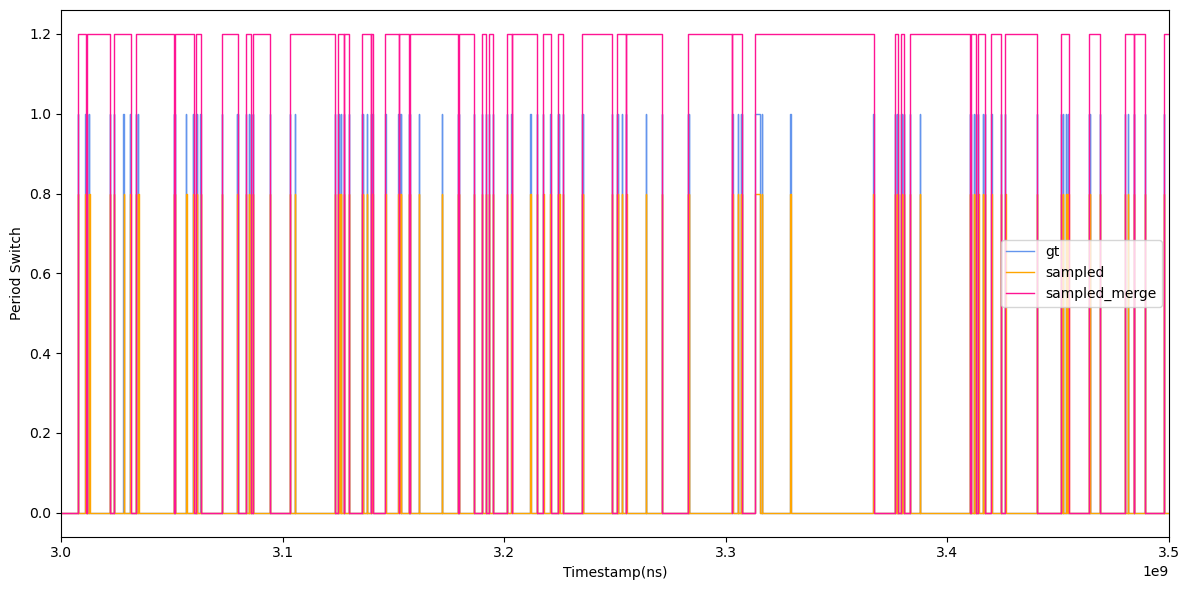

In [46]:
fig_idx=0
plt.figure(fig_idx,figsize=(12, 6))
plt.plot(timestamp_to_period_gt[:,0],timestamp_to_period_gt[:,1], label="gt", linewidth=1,color=color_list[0])

plt.plot(timestamp_to_period_sampled[:,0],timestamp_to_period_sampled[:,1], label="sampled", linewidth=1,color=color_list[1])

plt.plot(timestamp_to_period_sampled_merge[:,0],timestamp_to_period_sampled_merge[:,1], label="sampled_merge", linewidth=1,color=color_list[2])

plt.xlabel('Timestamp(ns)')
plt.ylabel('Period Switch')
plt.legend()

plt.xlim([3000000000, 3500000000])
# plt.ylim([80, 100])
plt.tight_layout()



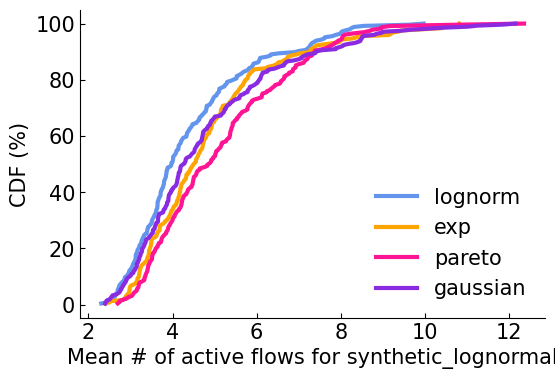

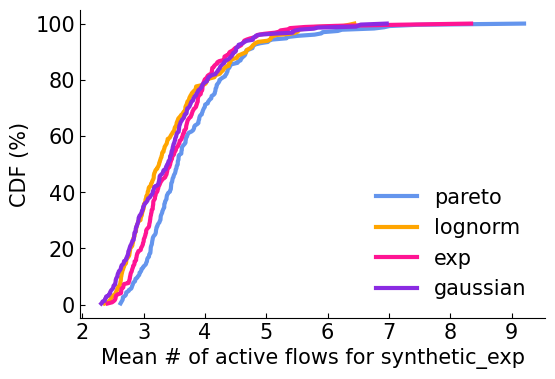

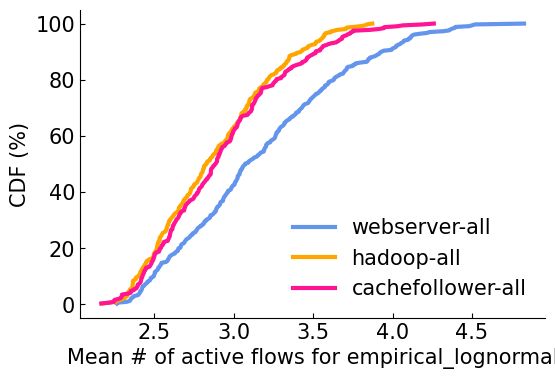

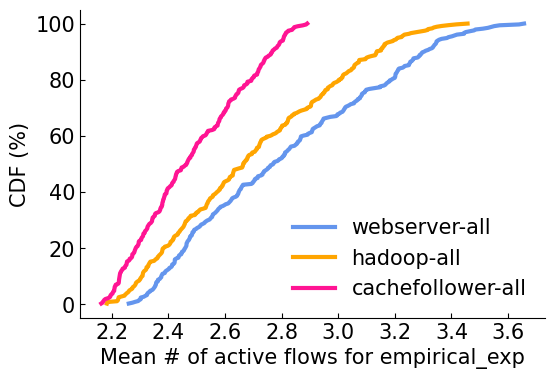

In [8]:
target_str_list=["_lognormal","_exp","_empirical_lognormal","_empirical_exp"]
target_legend_list=["synthetic_lognormal","synthetic_exp","empirical_lognormal","empirical_exp"]

fig_idx=0
for target_idx, target_str in enumerate(target_str_list):
    
    res_dict=defaultdict(list)
    
    result_file=f'./res/num_active_flows_queue{target_str}.npy'
    results = np.load(result_file, allow_pickle=True).item()
    num_active_flows_list = results["num_active_flows"]
    flow_sizes_list = results["flow_sizes"]
    
    for flow_size_idx,flow_sizes in enumerate(flow_sizes_list):
        res_dict[flow_sizes].append(np.mean(num_active_flows_list[flow_size_idx]))
    
    legend_list=list(res_dict.keys())
    plot_data=[np.array(res_dict[flow_sizes]) for flow_sizes in legend_list]
    plot_cdf(plot_data,None,legend_list,f'Mean # of active flows for {target_legend_list[target_idx]}',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=False,fig_idx=fig_idx)
    fig_idx+=1

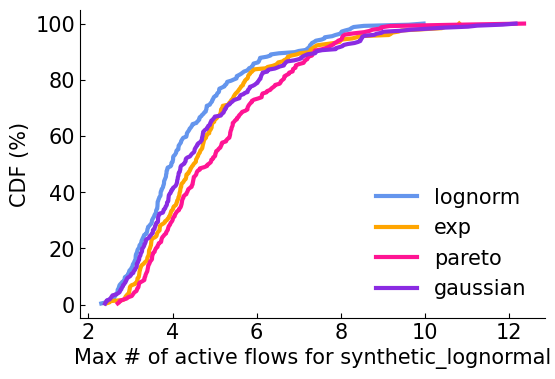

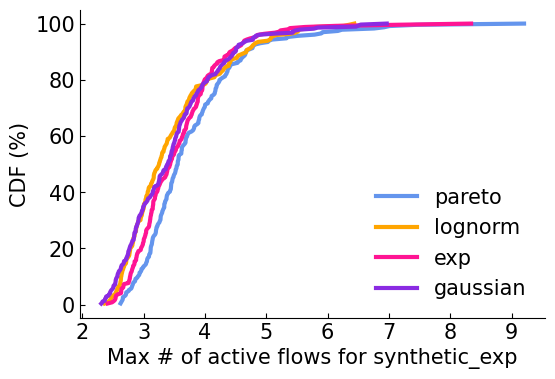

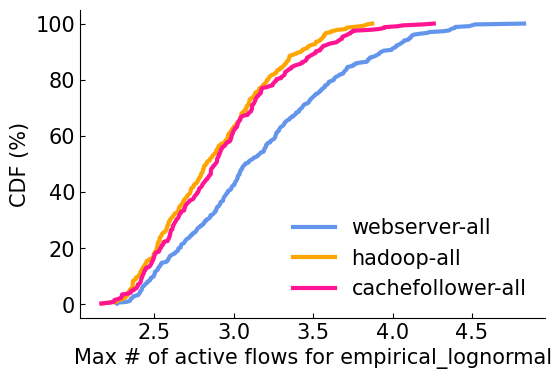

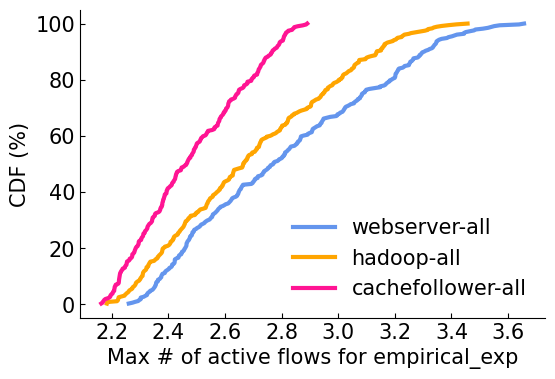

In [7]:
target_str_list=["_lognormal","_exp","_empirical_lognormal","_empirical_exp"]
target_legend_list=["synthetic_lognormal","synthetic_exp","empirical_lognormal","empirical_exp"]

fig_idx=0
for target_idx, target_str in enumerate(target_str_list):
    
    res_dict=defaultdict(list)
    
    result_file=f'./res/num_active_flows_queue{target_str}.npy'
    results = np.load(result_file, allow_pickle=True).item()
    num_active_flows_list = results["num_active_flows"]
    flow_sizes_list = results["flow_sizes"]
    
    for flow_size_idx,flow_sizes in enumerate(flow_sizes_list):
        res_dict[flow_sizes].append(np.max(num_active_flows_list[flow_size_idx]))
    
    legend_list=list(res_dict.keys())
    plot_data=[np.array(res_dict[flow_sizes]) for flow_sizes in legend_list]
    plot_cdf(plot_data,None,legend_list,f'Max # of active flows for {target_legend_list[target_idx]}',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=False,fig_idx=fig_idx)
    fig_idx+=1

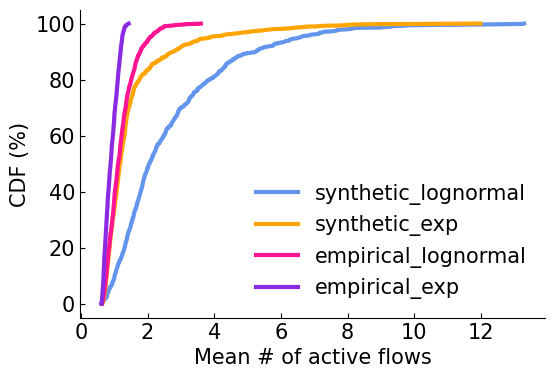

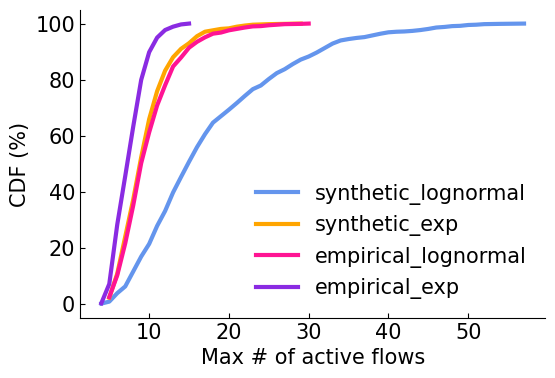

In [5]:
target_str_list=["_lognormal","_exp","_empirical_lognormal","_empirical_exp"]
legend_list=["synthetic_lognormal","synthetic_exp","empirical_lognormal","empirical_exp"]

fig_idx=0
res_mean=[]
res_max=[]
for target_str in target_str_list:
    result_file=f'./res/num_active_flows_time{target_str}.npy'
    results = np.load(result_file, allow_pickle=True).item()
    num_active_flows_list = results["num_active_flows"]
    
    res_tmp=[]
    for tmp in num_active_flows_list:
        res_tmp.append(np.mean(tmp))
    res_mean.append(np.array(res_tmp))
    
    res_tmp=[]
    for tmp in num_active_flows_list:
        res_tmp.append(np.max(tmp))
    res_max.append(np.array(res_tmp))
    
plot_cdf(res_mean,None,legend_list,'Mean # of active flows',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=False,fig_idx=fig_idx)
fig_idx+=1

plot_cdf(res_max,None,legend_list,'Max # of active flows',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=False,fig_idx=fig_idx)

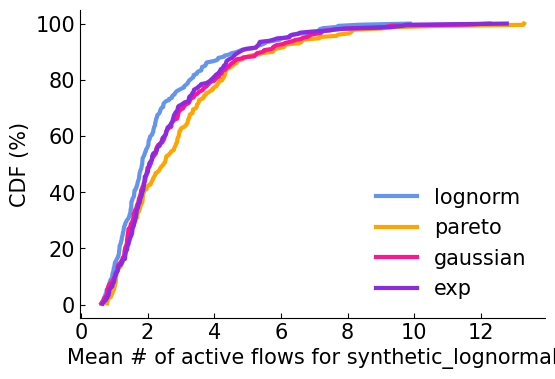

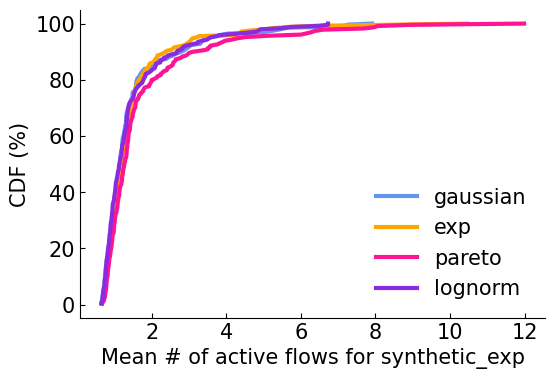

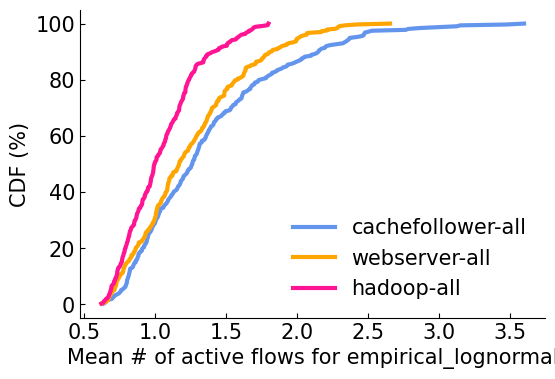

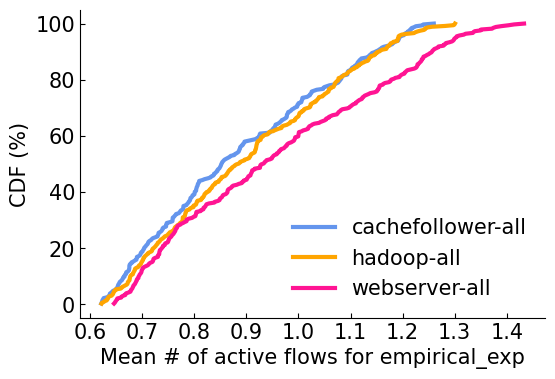

In [9]:
target_str_list=["_lognormal","_exp","_empirical_lognormal","_empirical_exp"]
target_legend_list=["synthetic_lognormal","synthetic_exp","empirical_lognormal","empirical_exp"]

fig_idx=0
for target_idx,target_str in enumerate(target_str_list):
    res_dict=defaultdict(list)
    
    result_file=f'./res/num_active_flows_time{target_str}.npy'
    results = np.load(result_file, allow_pickle=True).item()
    num_active_flows_list = results["num_active_flows"]
    flow_sizes_list = results["flow_sizes"]
    
    for flow_size_idx,flow_sizes in enumerate(flow_sizes_list):
        res_dict[flow_sizes].append(np.mean(num_active_flows_list[flow_size_idx]))
    
    legend_list=list(res_dict.keys())
    plot_data=[np.array(res_dict[flow_sizes]) for flow_sizes in legend_list]
    plot_cdf(plot_data,None,legend_list,f'Mean # of active flows for {target_legend_list[target_idx]}',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=False,fig_idx=fig_idx)
    fig_idx+=1

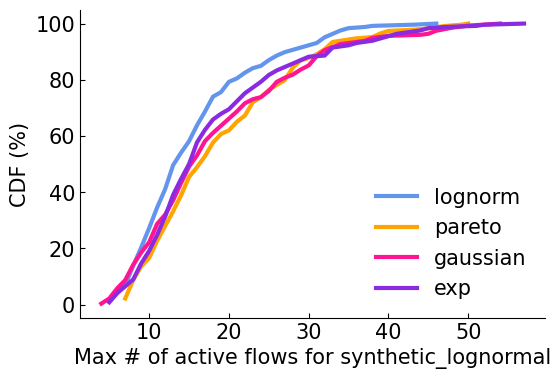

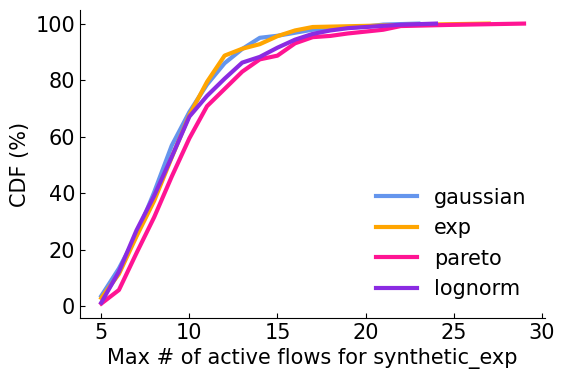

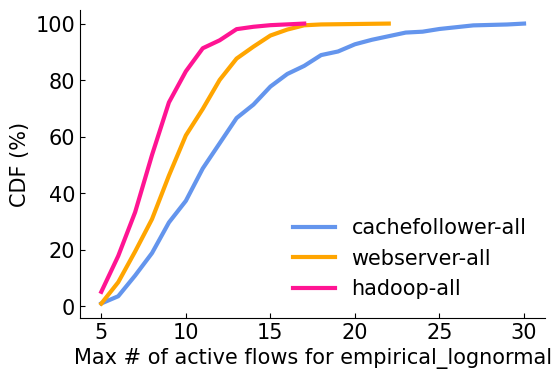

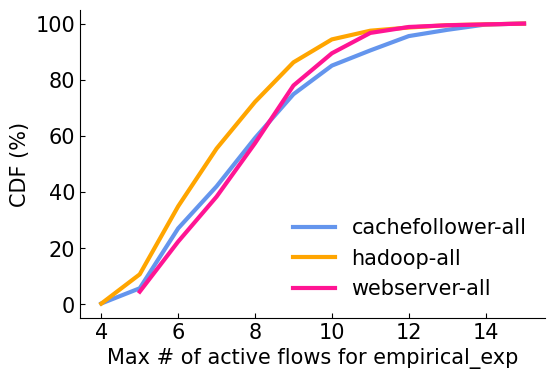

In [6]:
target_str_list=["_lognormal","_exp","_empirical_lognormal","_empirical_exp"]
target_legend_list=["synthetic_lognormal","synthetic_exp","empirical_lognormal","empirical_exp"]

fig_idx=0
for target_idx,target_str in enumerate(target_str_list):
    res_dict=defaultdict(list)
    
    result_file=f'./res/num_active_flows_time{target_str}.npy'
    results = np.load(result_file, allow_pickle=True).item()
    num_active_flows_list = results["num_active_flows"]
    flow_sizes_list = results["flow_sizes"]
    
    for flow_size_idx,flow_sizes in enumerate(flow_sizes_list):
        res_dict[flow_sizes].append(np.max(num_active_flows_list[flow_size_idx]))
    
    legend_list=list(res_dict.keys())
    plot_data=[np.array(res_dict[flow_sizes]) for flow_sizes in legend_list]
    plot_cdf(plot_data,None,legend_list,f'Max # of active flows for {target_legend_list[target_idx]}',legend_font=15,group_size=len(legend_list),loc=4,rotate_xaxis=False,log_switch=False,fig_idx=fig_idx)
    fig_idx+=1